In [1]:
from __future__ import print_function
import collections
import numpy as np
import pandas as pd
import pickle
import copy
import time

import sklearn
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.regularizers import l1
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
np.random.seed(7)

# create session explicitly and keep a reference
# so we can access and evaluate tensors directly 
sess = tf.Session()
K.set_session(sess)



Using TensorFlow backend.


In [2]:
# Global config variables 
model_name = "streeteye_lstm"
#data_file = "lstm_dump_test.txt"
data_file = "dump_2017_words.txt"

checkpoint_dir = "/home/ubuntu/mount/Notebooks/checkpoints"
tensorboard_dir ="/home/ubuntu/mount/Notebooks/tensorboard"


In [3]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
data=[]
y=[]

# count words
c = collections.Counter()

with open(data_file, "r") as infile:
    for line in infile:
        l = line.rstrip('\n').split(",")
        label = l.pop(0)
        # skip empty headlines
        if len(l[0]) == 0:
            continue
        if '' in l:
            l = [w for w in l if w]
        data.append(l)
        y.append(label)
        c.update(l)
        
print("Loaded data.")


Loading data...
Loaded data.


In [4]:
# create a list of top words        
vocabulary_size = 10000 # set this to have ~20 for least popular
count = [['UNK', -1]]
count.extend(c.most_common(vocabulary_size - 1))
print(count[:10])
print(count[-10:])

[['UNK', -1], ('domain_otherdomain', 119708), ('subsource_othersubsource', 47862), ('trump', 21141), ('with', 10761), ('domain_youtube.com', 8908), ('us', 8434), ('2017', 7862), ('from', 7768), ('subsource_memeorandum', 7712)]
[('hazard', 17), ('alexei', 17), ('molly', 17), ('expel', 17), ('champ', 17), ('admiral', 17), ('conversational', 17), ('memorable', 17), ('wharton', 17), ('torn', 17)]


In [5]:
dictionary = dict()
# map words into a dict of ints
for word, _ in count:
    dictionary[word] = len(dictionary)

data_embeddings=[]
unk_count = 0

for obs in data:
    embedlist = []
    for word in obs:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        embedlist.append(index)
    data_embeddings.append(embedlist)
        
count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [6]:
print(dictionary['trump'])
print(reverse_dictionary[3])

3
trump


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3ed1b0c90>]], dtype=object)

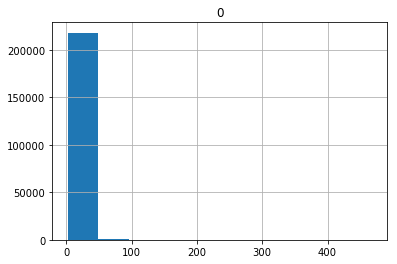

In [7]:
%matplotlib inline
ls = (map(len, data_embeddings))
pd.DataFrame(ls).hist()


In [8]:
MAX_LENGTH = 120
X = sequence.pad_sequences(data_embeddings, maxlen=MAX_LENGTH)
X[0]
X.shape

(218419, 120)

In [9]:
y=np.array(np.float32(y))

y=y.reshape((y.shape[0],1))
print(y.shape)
num_labels=1

num_obs, num_features = X.shape
print("Observations: %d\nFeatures: %d" % (num_obs, num_features))

# split into training, xval, test, 60/20/20
print("Split into training, temp")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
print("Split into xval, test")
X_xval, X_test, y_xval, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


(218419, 1)
Observations: 218419
Features: 120
Split into training, temp
Split into xval, test


In [10]:

print("Training set")
print(X_train.shape)

print("Xval set")
print(X_xval.shape)

print("Test set")
print(X_test.shape)

num_training_samples = X_train.shape[0]
num_xval_samples = X_xval.shape[0]
num_test_samples = X_test.shape[0]

print ("\nTraining observations:  %d  \nXval observations:  %d  \nTest observations:  %d\n" % (num_training_samples, num_xval_samples, num_test_samples))


Training set
(131051, 120)
Xval set
(43684, 120)
Test set
(43684, 120)

Training observations:  131051  
Xval observations:  43684  
Test observations:  43684



In [11]:
# initialize embeddings to pre-trained vals
pkl_file = open('embeddings.pkl', 'rb')
embeddings_dict, embeddings_reverse_dict, embeddings_data = pickle.load(pkl_file)

In [12]:
EMBEDDING_DIM=300

# +1 seems like an off-by-one somewhere
embedding_matrix = np.zeros((len(dictionary) + 1, EMBEDDING_DIM))

count = 0
for word, i in dictionary.items():
    #print(word)
    embed_i = embeddings_dict.get(word)
    if embed_i is not None:
        embedding_vector = embeddings_data[i]
        count +=1
        embedding_matrix[i] = embedding_vector
        
print("initialized %d embeddings" % count)

initialized 10000 embeddings


In [13]:
# function to generate model

def create_model(lstm_size=30, lstm_reg_penalty=0.0, sigmoid_dropout=(1.0/3.0), sigmoid_reg_penalty=0.0001):
    # create model
    model = Sequential()

    model.add(Embedding(len(dictionary) + 1, 
                        embedding_vector_length, 
                        weights=[embedding_matrix],
                        input_length=MAX_LENGTH,
                        trainable=True))
    
    # LSTM with lstm_size units
    model.add(LSTM(lstm_size,
                   kernel_regularizer=l1(lstm_reg_penalty)))
    model.add(Dropout(sigmoid_dropout))
    
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(sigmoid_reg_penalty)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


In [14]:
def selectThreshold (logits, labels, beta=(2.0/3)):
    # return threshold, f-score that yields best F-score
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    bb = beta**2
    f1_scores = (1 + bb) * precision * recall / (bb * precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)

In [ ]:
# grid search
embedding_vector_length = EMBEDDING_DIM

for sig_reg_penalty in [0.00003, 0.0003]:
    for dropout in [0.333, 0.5]:
        for lstm_units in [16, 32, 64, 128]:
            for lstm_reg_penalty in [0.00000,]:
                #0.000001, 0.000003, 0.00001, 0.00003]:
                models = []
                xval_losses = []

                model = create_model(lstm_size=lstm_units, 
                                     lstm_reg_penalty=lstm_reg_penalty, 
                                     sigmoid_dropout=dropout, 
                                     sigmoid_reg_penalty=sig_reg_penalty)
                print('%s Starting (unfrozen)...' % time.strftime("%H:%M:%S"))
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)

                ##################################################################
                # train end-to-end including embeddings until xval loss bottoms out
                ##################################################################
                
                epochs = 10
                for _ in range(epochs):
                    fit = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=1, batch_size=1024)
                    # save loss
                    train_loss = fit.history['loss'][-1]
                    train_acc = fit.history['acc'][-1]
                    xval_loss = fit.history['val_loss'][-1]
                    xval_acc = fit.history['val_acc'][-1]
                    xval_losses.append(xval_loss)
                    models.append(copy.copy(model))

                    bestloss_index = np.argmin(xval_losses)
                    bestloss_value = xval_losses[bestloss_index]

                    # break if loss rises by 10% from best
                    if xval_loss / bestloss_value > 1.1:
                        break
                    
                # keep model from epoch with best xval loss
                print ("%s Best Xval loss epoch %d, value %f" % (time.strftime("%H:%M:%S"), bestloss_index, bestloss_value))
                model = models[bestloss_index]

                print('%s Finished (unfrozen)...' % time.strftime("%H:%M:%S"))
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)                
                
                y_train_prob = model.predict(X_train)
                
                beta=(2.0/3.0) # penalize false positives more than false negatives
                thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
                y_train_pred = y_train_prob >= thresh

                
                print("%s Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (time.strftime("%H:%M:%S"),
                       sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
                y_xval_pred = y_xval_prob >= thresh
                
                print("%s Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (time.strftime("%H:%M:%S"),
                       sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval),
                       score, beta))
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                false_positive = confusion_matrix[1][0]
                false_negative = confusion_matrix[0][1]
                true_positive = confusion_matrix[1][1]
                raw_score = 1.0 * (true_positive - false_positive) / np.sum(confusion_matrix)
                print ("Raw score 2 %f" % raw_score)

                ##################################################################
                # freeze embeddings, train LSTM until xval loss bottoms out
                ##################################################################
                elayer = model.layers[0]
                
                elayer.trainable = False
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                print(model.summary())

                # Could also keep existing list of models in case further training makes it worse                
                models = []
                xval_losses = []
                epochs = 20

                print('%s Continuing (frozen)...' % time.strftime("%H:%M:%S"))

                for _ in range(epochs):
                    fit = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=1, batch_size=1024)
                    # save losses
                    train_loss = fit.history['loss'][-1]
                    train_acc = fit.history['acc'][-1]
                    xval_loss = fit.history['val_loss'][-1]
                    xval_acc = fit.history['val_acc'][-1]
                    xval_losses.append(xval_loss)
                    models.append(copy.copy(model))

                    bestloss_index = np.argmin(xval_losses)
                    bestloss_value = xval_losses[bestloss_index]
    
                    # break if loss rises by 10% from best
                    if xval_loss / bestloss_value > 1.1:
                        break
                    
                # keep model from epoch with best xval loss
                print ("%s Best Xval loss epoch %d, value %f" % (time.strftime("%H:%M:%S"), bestloss_index, bestloss_value))
                # actually go back one from best... best is usually already overfitted with .9 train f1
                if bestloss_index > 0:
                    bestloss_index -= 1
                model = models[bestloss_index]

                print('%s Finished (frozen)...' % time.strftime("%H:%M:%S"))
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)                
               
                y_train_prob = model.predict(X_train)
                
                beta=(2.0/3.0) # penalize false positives more than false negatives
                thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
                y_train_pred = y_train_prob >= thresh
                
                print("%s Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (time.strftime("%H:%M:%S"),
                       sklearn.metrics.accuracy_score(y_train_pred, y_train),
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
                y_xval_pred = y_xval_prob >= thresh

                print("%s Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (time.strftime("%H:%M:%S"),
                       sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval),
                       score, beta))
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                false_positive = confusion_matrix[1][0]
                false_negative = confusion_matrix[0][1]
                true_positive = confusion_matrix[1][1]

                raw_score = 1.0 * (true_positive - false_positive) / np.sum(confusion_matrix)
                print ("Raw score 2 %f" % raw_score)
                
                # save model to disk
                print('%s Saving...' % time.strftime("%H:%M:%S"))               
                modelname = "model_%d_%.6f_%.3f_%.6f" % (lstm_units, lstm_reg_penalty, dropout, sig_reg_penalty)
                model.save("%s.h5" % modelname)
                model.save_weights("%s_weights.h5" % modelname)
                with open("%s.json" % modelname, "wb") as fjson:
                    fjson.write(model.to_json()) 
                    
                                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 300)          3000300   
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 3,020,605.0
Trainable params: 3,020,605.0
Non-trainable params: 0.0
_________________________________________________________________
None
15:34:24 Starting (unfrozen)...
LSTM units 16
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.3330
Sigmoid reg_penalty 0.00003000
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 166s - loss: 0.

Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 230s - loss: 0.0181 - acc: 0.9957 - val_loss: 0.0698 - val_acc: 0.9817
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 228s - loss: 0.0167 - acc: 0.9961 - val_loss: 0.0726 - val_acc: 0.9824
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 228s - loss: 0.0159 - acc: 0.9963 - val_loss: 0.0765 - val_acc: 0.9820
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 228s - loss: 0.0153 - acc: 0.9963 - val_loss: 0.0820 - val_acc: 0.9824
16:55:54 Best Xval loss epoch 0, value 0.069758
16:55:54 Finished (frozen)...
LSTM units 32
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.3330
Sigmoid reg_penalty 0.00003000
16:57:44 Train Accuracy 0.997, Train F1 0.937, f_score 0.944 (beta 0.667)
[[127312    298]
 [   148   

Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 932s - loss: 0.0169 - acc: 0.9953 - val_loss: 0.0868 - val_acc: 0.9820
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 931s - loss: 0.0159 - acc: 0.9956 - val_loss: 0.0752 - val_acc: 0.9806
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 931s - loss: 0.0150 - acc: 0.9959 - val_loss: 0.0764 - val_acc: 0.9804
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 931s - loss: 0.0146 - acc: 0.9959 - val_loss: 0.0774 - val_acc: 0.9805
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 928s - loss: 0.0138 - acc: 0.9964 - val_loss: 0.0822 - val_acc: 0.9819
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [===================

131051/131051 [==============================] - 269s - loss: 0.0421 - acc: 0.9875 - val_loss: 0.0498 - val_acc: 0.9839
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 269s - loss: 0.0316 - acc: 0.9910 - val_loss: 0.0576 - val_acc: 0.9836
23:03:11 Best Xval loss epoch 4, value 0.049847
23:03:11 Finished (unfrozen)...
LSTM units 32
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.5000
Sigmoid reg_penalty 0.00003000
23:05:02 Train Accuracy 0.994, Train F1 0.897, f_score 0.907 (beta 0.667)
[[127206    467]
 [   254   3124]]
23:05:39 Xval Accuracy 0.984, Xval F1 0.685, f_score 0.720 (beta 0.667)
[[42197   499]
 [  214   774]]
Raw score 2 0.012819
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 300)          3000300   
_________________________________________________________________
lstm_11 (LSTM)            

131051/131051 [==============================] - 1047s - loss: 0.1575 - acc: 0.9689 - val_loss: 0.1249 - val_acc: 0.9709
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 1047s - loss: 0.0854 - acc: 0.9743 - val_loss: 0.0530 - val_acc: 0.9818
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 1047s - loss: 0.0400 - acc: 0.9867 - val_loss: 0.0505 - val_acc: 0.9826
Train on 131051 samples, validate on 43684 samples
Epoch 1/1
131051/131051 [==============================] - 1046s - loss: 0.0314 - acc: 0.9902 - val_loss: 0.0563 - val_acc: 0.9831
01:56:27 Best Xval loss epoch 2, value 0.050534
01:56:27 Finished (unfrozen)...
LSTM units 128
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.5000
Sigmoid reg_penalty 0.00003000
02:02:05 Train Accuracy 0.994, Train F1 0.886, f_score 0.896 (beta 0.667)
[[127163    498]
 [   297   3093]]
02:03:57 Xval Accuracy 0.983, Xval F1 0.679, f_

In [ ]:
#load best model and evaluate in test set
y_test_prob = model.predict(X_test)
beta=(2.0/3.0) # penalize false positives more than false negatives

y_test_pred = y_test_prob >= thresh
print("Test Accuracy %.3f, Test F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_test_pred, y_test), 
                       sklearn.metrics.f1_score(y_test_pred, y_test),
                       score, beta))
                
print(sklearn.metrics.confusion_matrix(y_test_pred, y_test))
